In [4]:
#Dataset from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import linear_model, model_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import nltk

##Reading Datasets

In [2]:
fake = pd.read_csv("./Fake.csv")
real = pd.read_csv("./Real.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
real.shape

(21417, 4)

##Preparing and cleaning the data

In [5]:
#Setting a flag to distinguish between real and fake datasets
fake['target'] = 'fake'
real['target'] = 'real'

In [6]:
# Concatenating the dataframes
data = pd.concat([fake, real]).reset_index(drop=True)
data.shape

# Shuffling the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

data.head()

,title,text,subject,date,target
0,Chile election ends era of female presidents i...,SANTIAGO (Reuters) - When Chile s President Mi...,worldnews,"December 19, 2017",real
1,NUTTY LEFTY Breaks Into TRUMP’S Mar-A-Lago Clu...,"PALM BEACH, Fla. (AP) A woman is being charg...",politics,"Jan 24, 2017",fake
2,Trump says thinks Republicans have the votes t...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"October 20, 2017",real
3,RETIRED COP PENS Gut-Wrenching VIRAL Letter To...,It s easy to see why this letter went viral. B...,politics,"Aug 31, 2016",fake
4,Voice of triumph or doom: North Korean present...,SEOUL (Reuters) - Wearing a pink Korean dress ...,worldnews,"September 4, 2017",real


In [7]:
#Removing the date column from the data
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Chile election ends era of female presidents i...,SANTIAGO (Reuters) - When Chile s President Mi...,worldnews,real
1,NUTTY LEFTY Breaks Into TRUMP’S Mar-A-Lago Clu...,"PALM BEACH, Fla. (AP) A woman is being charg...",politics,fake
2,Trump says thinks Republicans have the votes t...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,real
3,RETIRED COP PENS Gut-Wrenching VIRAL Letter To...,It s easy to see why this letter went viral. B...,politics,fake
4,Voice of triumph or doom: North Korean present...,SEOUL (Reuters) - Wearing a pink Korean dress ...,worldnews,real


In [8]:
#Removing the title column
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,SANTIAGO (Reuters) - When Chile s President Mi...,worldnews,real
1,"PALM BEACH, Fla. (AP) A woman is being charg...",politics,fake
2,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,real
3,It s easy to see why this letter went viral. B...,politics,fake
4,SEOUL (Reuters) - Wearing a pink Korean dress ...,worldnews,real


In [9]:
#Converting the text column to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,santiago (reuters) - when chile s president mi...,worldnews,real
1,"palm beach, fla. (ap) a woman is being charg...",politics,fake
2,washington (reuters) - u.s. president donald t...,politicsNews,real
3,it s easy to see why this letter went viral. b...,politics,fake
4,seoul (reuters) - wearing a pink korean dress ...,worldnews,real


In [10]:
#Removing punctuation from text
def punctuation_remove(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_remove)
data.head()

,text,subject,target
0,santiago reuters when chile s president miche...,worldnews,real
1,palm beach fla ap a woman is being charged w...,politics,fake
2,washington reuters us president donald trump ...,politicsNews,real
3,it s easy to see why this letter went viral br...,politics,fake
4,seoul reuters wearing a pink korean dress and...,worldnews,real


In [11]:
#Removing stopwords from text
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data.head()

[nltk_data] Downloading package stopwords to /home/mohit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,subject,target
0,santiago reuters chile president michelle bach...,worldnews,real
1,palm beach fla ap woman charged sneaking onto ...,politics,fake
2,washington reuters us president donald trump s...,politicsNews,real
3,easy see letter went viral bravo officer chris...,politics,fake
4,seoul reuters wearing pink korean dress flashi...,worldnews,real


##Exploring the data

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


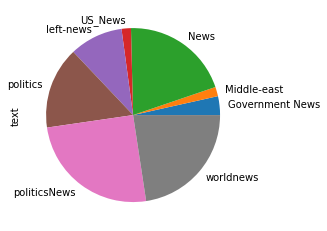

In [12]:
#Number of articles per subject
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="pie")
plt.show()

target
fake    23481
real    21417
Name: text, dtype: int64


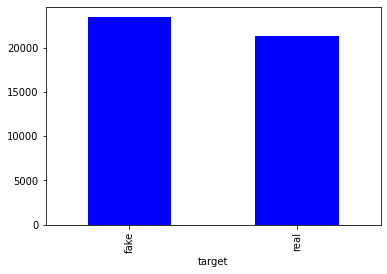

In [13]:
#Number of fake and real articles
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar", color="blue")
plt.show()

In [23]:
#Counting the most frequently occuring words in text
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'red')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

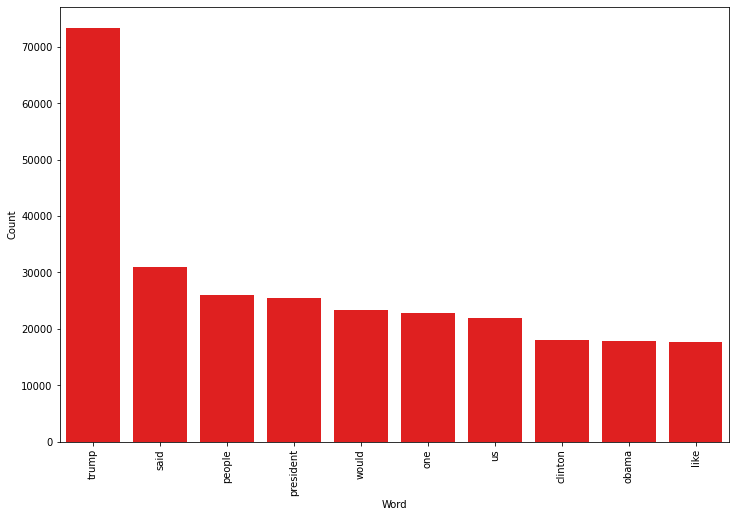

In [24]:
# The top 15 most frequently occuring words in FAKE news
counter(data[data["target"] == "fake"], "text", 10)

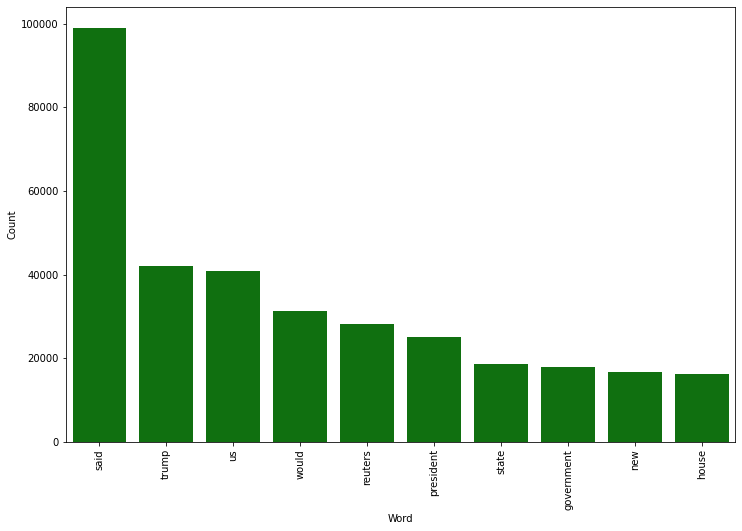

In [22]:
#The top 15 most frequently occuring words in REAL news
counter(data[data["target"] == "real"], "text", 10)

In [17]:
#Vectorizing and applying TF-IDF
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LogisticRegression())])

#Fitting the model
model = pipe.fit(X_train, y_train)

#Model Accuracy
prediction = model.predict(X_test)
print("Model Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

Model Accuracy: 98.88%


In [18]:
# Function to plot confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(c_matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(c_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    threshold_v = c_matrix.max() / 2.
    for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
        plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color="white" if c_matrix[i, j] > threshold_v else "black")

    plt.tight_layout()
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')

Confusion matrix, without normalization


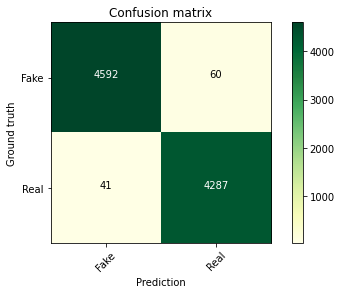

In [19]:
#Plotting the confusion matrix
c_matrix = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(c_matrix, classes=['Fake', 'Real'], cmap="YlGn")